# ECON 5140: Applied Econometrics
## Lesson 7: Potential Outcomes Framework and Causal Inference

This notebook demonstrates key concepts from Lesson 7 using concrete numerical examples and simulations.

**Topics covered:**
1. Potential outcomes: ATE, ATT, ATU
2. Simple difference in outcomes (SDO) vs causal effects
3. Selection bias and the bias decomposition
4. Random assignment: when SDO = ATE
5. Confounding and regression: when OLS fails and when it works
6. DAGs: visualizing confounding and colliders

## Part 1: The 10-Patient Example (from Lecture)

Ten cancer patients, two treatments:
- **D = 1**: Surgery
- **D = 0**: Chemotherapy

Patients are assigned to treatment with "perfect wisdom" (they choose the treatment that gives them the better outcome). This creates selection: treatment is *not* random.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [2]:
# Data from the lecture slides (10 patients)
df = pd.DataFrame({
    'patient': range(1, 11),
    'Y1': [7, 5, 5, 7, 4, 10, 1, 5, 3, 9],   # Outcome under surgery
    'Y0': [1, 6, 1, 8, 2, 1, 10, 6, 7, 8],   # Outcome under chemo
})
df['delta'] = df['Y1'] - df['Y0']  # Individual treatment effect

# Assignment with "perfect wisdom": choose treatment that gives better outcome
df['D'] = (df['Y1'] > df['Y0']).astype(int)

# Observed outcome: Y = D*Y1 + (1-D)*Y0
df['Y_obs'] = df['D'] * df['Y1'] + (1 - df['D']) * df['Y0']

print("10-Patient Data:")
print(df.to_string(index=False))
print()

10-Patient Data:
 patient  Y1  Y0  delta  D  Y_obs
       1   7   1      6  1      7
       2   5   6     -1  0      6
       3   5   1      4  1      5
       4   7   8     -1  0      8
       5   4   2      2  1      4
       6  10   1      9  1     10
       7   1  10     -9  0     10
       8   5   6     -1  0      6
       9   3   7     -4  0      7
      10   9   8      1  1      9



In [3]:
# --- Causal estimands (we can compute these because we have BOTH potential outcomes) ---
ATE = (df['Y1'] - df['Y0']).mean()
ATT = df.loc[df['D'] == 1, 'delta'].mean()  # Among those who got surgery
ATU = df.loc[df['D'] == 0, 'delta'].mean()  # Among those who got chemo

p = df['D'].mean()  # Pr(D=1)
print("Causal estimands (from potential outcomes):")
print(f"  ATE = E[Y(1) - Y(0)] = {ATE:.2f}")
print(f"  ATT = E[Y(1) - Y(0) | D=1] = {ATT:.2f}")
print(f"  ATU = E[Y(1) - Y(0) | D=0] = {ATU:.2f}")
print(f"  ATE = p*ATT + (1-p)*ATU = {p:.1f}*{ATT:.2f} + {1-p:.1f}*{ATU:.2f} = {p*ATT + (1-p)*ATU:.2f}")
print()

Causal estimands (from potential outcomes):
  ATE = E[Y(1) - Y(0)] = 0.60
  ATT = E[Y(1) - Y(0) | D=1] = 4.40
  ATU = E[Y(1) - Y(0) | D=0] = -3.20
  ATE = p*ATT + (1-p)*ATU = 0.5*4.40 + 0.5*-3.20 = 0.60



In [4]:
# --- Simple Difference in Outcomes (what we observe in practice) ---
mean_Y_treated = df.loc[df['D'] == 1, 'Y_obs'].mean()
mean_Y_control = df.loc[df['D'] == 0, 'Y_obs'].mean()
SDO = mean_Y_treated - mean_Y_control

print("Simple Difference in Outcomes (naive comparison):")
print(f"  E[Y|D=1] = {mean_Y_treated:.2f}")
print(f"  E[Y|D=0] = {mean_Y_control:.2f}")
print(f"  SDO = E[Y|D=1] - E[Y|D=0] = {SDO:.2f}")
print()
print("SDO ≠ ATE! The naive comparison is biased because of selection.")
print(f"Bias = SDO - ATE = {SDO - ATE:.2f}")

Simple Difference in Outcomes (naive comparison):
  E[Y|D=1] = 7.00
  E[Y|D=0] = 7.40
  SDO = E[Y|D=1] - E[Y|D=0] = -0.40

SDO ≠ ATE! The naive comparison is biased because of selection.
Bias = SDO - ATE = -1.00


In [5]:
# --- Bias decomposition (from lecture) ---
# SDO = ATE + Selection bias + HTE bias

E_Y0_D1 = df.loc[df['D'] == 1, 'Y0'].mean()  # Avg Y(0) among treated
E_Y0_D0 = df.loc[df['D'] == 0, 'Y0'].mean()  # Avg Y(0) among control
selection_bias = E_Y0_D1 - E_Y0_D0
hte_bias = p * (ATT - ATU)

print("Bias decomposition:")
print(f"  1. ATE = {ATE:.2f}")
print(f"  2. Selection bias = E[Y(0)|D=1] - E[Y(0)|D=0] = {E_Y0_D1:.2f} - {E_Y0_D0:.2f} = {selection_bias:.2f}")
print(f"     (Treated would have done worse under chemo than control did)")
print(f"  3. HTE bias = p*(ATT - ATU) = {p:.2f}*({ATT:.2f} - ({ATU:.2f})) = {hte_bias:.2f}")
print()
print(f"  SDO = ATE + Selection bias + HTE bias")
print(f"  SDO = {ATE:.2f} + ({selection_bias:.2f}) + {hte_bias:.2f} = {ATE + selection_bias + hte_bias:.2f}")
print()
print("Interpretation: Unless selection bias = 0, the difference in means is not causal.")

Bias decomposition:
  1. ATE = 0.60
  2. Selection bias = E[Y(0)|D=1] - E[Y(0)|D=0] = 2.60 - 7.40 = -4.80
     (Treated would have done worse under chemo than control did)
  3. HTE bias = p*(ATT - ATU) = 0.50*(4.40 - (-3.20)) = 3.80

  SDO = ATE + Selection bias + HTE bias
  SDO = 0.60 + (-4.80) + 3.80 = -0.40

Interpretation: Unless selection bias = 0, the difference in means is not causal.


## Part 2: Random Assignment — When SDO = ATE

If treatment were **randomly assigned**, then (Y(1), Y(0)) ⊥ D. In that case:
- E[Y(0)|D=1] = E[Y(0)|D=0] → selection bias = 0
- SDO = ATE

We simulate the same 10 patients but now assign D randomly (coin flip).

In [6]:
# Same potential outcomes, but RANDOM assignment
np.random.seed(123)
df_rand = df[['patient', 'Y1', 'Y0', 'delta']].copy()
df_rand['D'] = np.random.binomial(1, 0.5, size=10)  # Random 50-50 assignment
df_rand['Y_obs'] = df_rand['D'] * df_rand['Y1'] + (1 - df_rand['D']) * df_rand['Y0']

SDO_rand = df_rand.loc[df_rand['D'] == 1, 'Y_obs'].mean() - df_rand.loc[df_rand['D'] == 0, 'Y_obs'].mean()

print("With RANDOM assignment:")
print(f"  ATE (unchanged) = {ATE:.2f}")
print(f"  SDO = {SDO_rand:.2f}")
print(f"  SDO ≈ ATE? {abs(SDO_rand - ATE) < 1.0}")
print()
print("With only 10 units, SDO is noisy but unbiased. With many units, SDO → ATE.")

With RANDOM assignment:
  ATE (unchanged) = 0.60
  SDO = 0.20
  SDO ≈ ATE? True

With only 10 units, SDO is noisy but unbiased. With many units, SDO → ATE.


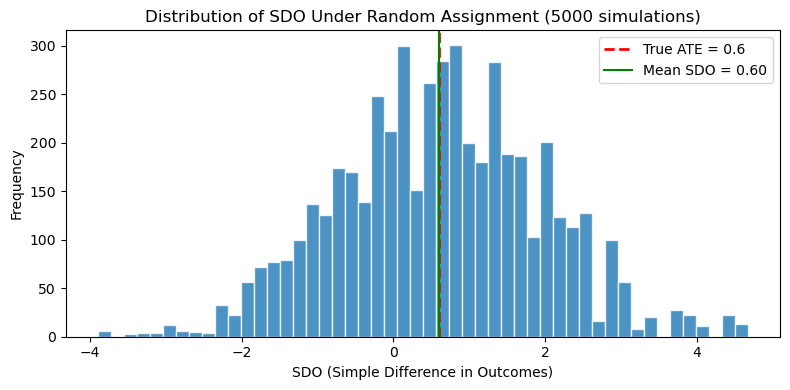

Mean of SDO across simulations: 0.60 (should equal ATE = 0.6)


In [11]:
# Simulate many random assignments to show SDO converges to ATE
# Note: With n=10, sometimes all units get assigned to one group (all D=1 or all D=0).
# When that happens, one group is empty and .mean() returns nan. We skip those.
n_sim = 5000
sdo_list = []
for _ in range(n_sim):
    D_sim = np.random.binomial(1, 0.5, size=10)
    Y_obs_sim = D_sim * df['Y1'].values + (1 - D_sim) * df['Y0'].values
    if D_sim.sum() > 0 and D_sim.sum() < 10:  # Need both groups non-empty
        sdo = Y_obs_sim[D_sim == 1].mean() - Y_obs_sim[D_sim == 0].mean()
        sdo_list.append(sdo)

plt.figure(figsize=(8, 4))
plt.hist(sdo_list, bins=50, edgecolor='white', alpha=0.8)
plt.axvline(ATE, color='red', linestyle='--', linewidth=2, label=f'True ATE = {ATE}')
plt.axvline(np.mean(sdo_list), color='green', linestyle='-', linewidth=1.5, label=f'Mean SDO = {np.mean(sdo_list):.2f}')
plt.xlabel('SDO (Simple Difference in Outcomes)')
plt.ylabel('Frequency')
plt.title('Distribution of SDO Under Random Assignment (5000 simulations)')
plt.legend()
plt.tight_layout()
plt.show()
print(f"Mean of SDO across simulations: {np.mean(sdo_list):.2f} (should equal ATE = {ATE})")

## Part 3: Confounding and Regression

**Setup:** We want to estimate the effect of training (D) on earnings (Y). But ability (X) affects both:
- Higher ability → more likely to get training
- Higher ability → higher earnings

X is a **confounder**. The DAG: D ← X → Y (and D → Y).

**Naive regression** Y = α + βD + ε: β captures association, not causation.

**Correct regression** Y = α + βD + γX + ε: controlling for X blocks the backdoor path; β estimates the causal effect.

In [8]:
# Simulate data with confounding
# True DGP: Y = 50 + 10*D + 5*X + noise (causal effect of D = 10)
# D is influenced by X: higher X → more likely D=1

np.random.seed(42)
n = 1000
X = np.random.normal(0, 1, n)  # Ability (standardized)
D = (np.random.uniform(0, 1, n) < 0.3 + 0.4 * (X > 0)).astype(int)  # X increases Pr(D=1)
Y = 50 + 10*D + 5*X + np.random.normal(0, 5, n)  # True causal effect of D = 10

df_conf = pd.DataFrame({'Y': Y, 'D': D, 'X': X})

# Naive regression: Y ~ D (omit X)
X_naive = sm.add_constant(df_conf['D'])
model_naive = OLS(df_conf['Y'], X_naive).fit()

# Correct regression: Y ~ D + X
X_correct = sm.add_constant(df_conf[['D', 'X']])
model_correct = OLS(df_conf['Y'], X_correct).fit()

print("Naive regression (Y ~ D): omitting confounder X")
print(model_naive.summary().tables[1])
print()
print("Correct regression (Y ~ D + X): controlling for confounder")
print(model_correct.summary().tables[1])
print()
print("True causal effect of D: 10")
print(f"Naive β (biased): {model_naive.params['D']:.2f}")
print(f"Correct β (unbiased): {model_correct.params['D']:.2f}")

Naive regression (Y ~ D): omitting confounder X
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.7323      0.308    158.360      0.000      48.128      49.336
D             12.9211      0.439     29.452      0.000      12.060      13.782

Correct regression (Y ~ D + X): controlling for confounder
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.1676      0.219    228.794      0.000      49.737      50.598
D              9.7948      0.321     30.515      0.000       9.165      10.425
X              5.3183      0.164     32.437      0.000       4.997       5.640

True causal effect of D: 10
Naive β (biased): 12.92
Correct β (unbiased): 9.79


## Part 4: DAGs — Visualizing Confounding and Colliders

DAGs encode causal assumptions. We draw:
1. **Confounding**: D ← X → Y and D → Y. X is a confounder; we must control for it.
2. **Collider**: D → X ← Y. X is a collider; conditioning on X *creates* bias (opens a backdoor).

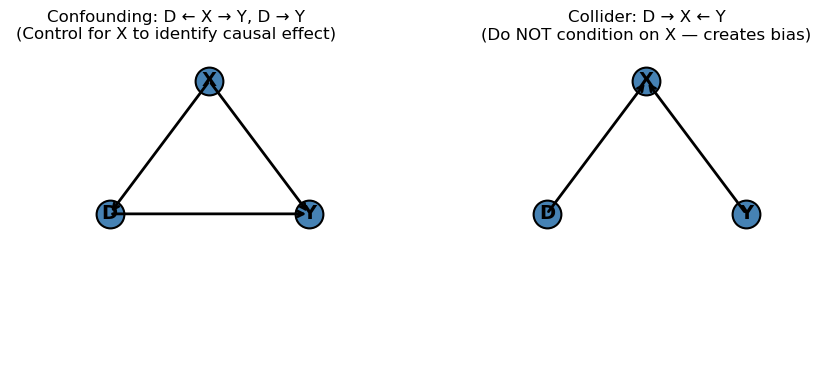

In [9]:
def draw_dag(edges, title, ax):
    """Draw a simple DAG. edges: list of (from, to) tuples."""
    pos = {'D': (0.5, 0.5), 'Y': (1, 0.5), 'X': (0.75, 0.9)}
    for i, (a, b) in enumerate(edges):
        if a not in pos:
            pos[a] = (0.2 + 0.3*i, 0.2)
        if b not in pos:
            pos[b] = (0.8 - 0.3*i, 0.8)
    
    # Adjust for common DAGs
    if ('X', 'D') in edges or ('D', 'X') in edges:
        pos = {'D': (0.3, 0.5), 'Y': (0.9, 0.5), 'X': (0.6, 0.9)}
    if ('D', 'X') in edges and ('Y', 'X') in edges:  # Collider
        pos = {'D': (0.2, 0.5), 'Y': (0.8, 0.5), 'X': (0.5, 0.9)}
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.axis('off')
    
    for (a, b) in edges:
        x1, y1 = pos[a]
        x2, y2 = pos[b]
        ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                    arrowprops=dict(arrowstyle='->', color='black', lw=2))
    
    for node, (x, y) in pos.items():
        ax.plot(x, y, 'o', markersize=20, color='steelblue', markeredgecolor='black', markeredgewidth=1.5)
        ax.text(x, y, node, ha='center', va='center', fontsize=14, fontweight='bold')
    
    ax.set_title(title, fontsize=12)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Confounding: D <- X -> Y, D -> Y
draw_dag([('X', 'D'), ('X', 'Y'), ('D', 'Y')], 'Confounding: D ← X → Y, D → Y\n(Control for X to identify causal effect)', axes[0])

# Collider: D -> X <- Y
draw_dag([('D', 'X'), ('Y', 'X')], 'Collider: D → X ← Y\n(Do NOT condition on X — creates bias)', axes[1])

plt.tight_layout()
plt.show()

In [10]:
# Demonstrate collider bias with simulation
# D and Y are independent in population. But both cause X (collider).
# If we condition on X (e.g., restrict to X=1), D and Y become associated.

np.random.seed(42)
n = 5000
D = np.random.binomial(1, 0.5, n)  # Random
Y = np.random.normal(0, 1, n)      # Independent of D
X = D + Y + np.random.normal(0, 0.5, n)  # Collider: both D and Y cause X

print("Collider bias demonstration:")
print(f"  In full sample: Corr(D, Y) = {np.corrcoef(D, Y)[0,1]:.3f} (should be ~0)")

# Condition on X being high (top 25%)
high_X = X > np.percentile(X, 75)
D_cond = D[high_X]
Y_cond = Y[high_X]
print(f"  Conditioning on X high: Corr(D, Y) = {np.corrcoef(D_cond, Y_cond)[0,1]:.3f}")
print()
print("  Interpretation: Among those with high X, D and Y are negatively associated.")
print("  (High D + low Y can give high X; low D + high Y can also give high X.)")
print("  Conditioning on the collider creates spurious correlation.")

Collider bias demonstration:
  In full sample: Corr(D, Y) = -0.019 (should be ~0)
  Conditioning on X high: Corr(D, Y) = -0.398

  Interpretation: Among those with high X, D and Y are negatively associated.
  (High D + low Y can give high X; low D + high Y can also give high X.)
  Conditioning on the collider creates spurious correlation.


## Summary

1. **Potential outcomes** define causal effects (ATE, ATT, ATU) but are never fully observed.
2. **SDO = E[Y|D=1] - E[Y|D=0]** equals ATE only under random assignment. With selection, SDO is biased.
3. **Random assignment** eliminates selection bias; RCTs are the gold standard.
4. **Confounders** create backdoor paths; we must control for them to identify causal effects.
5. **Colliders** are different: conditioning on them *creates* bias. Do not control for colliders.
6. **Regression** estimates causal effects only when identification assumptions hold. Interpretation is a causal decision, not a statistical reflex.